In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [ ]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

In [ ]:
RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 40
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((16, 16)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])


test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((16, 16)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([256, 3, 16, 16])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([0, 9, 2, 5, 2, 1, 4, 2, 7, 7])


In [ ]:
class CNN1(torch.nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.features = torch.nn.Sequential(
            # Conv 1
            torch.nn.Conv2d(3, 16, kernel_size=3, padding="same"), # output 16 - 3 + 1 => 16
                            # , stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), # 16 / 2 => output 8

            # Conv 2
            torch.nn.Conv2d(16, 32, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 8
                            # , padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2) #output 8 / 2 => output 4
    )

    self.classifier = torch.nn.Sequential(
         torch.nn.Linear(32*4*4, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    # print(x.size())
    logits = self.classifier(x)
    return logits

In [ ]:
model1 = CNN1(num_classes=10)

In [ ]:
model1 = model1.to(DEVICE)

In [ ]:
optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model1,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


Epoch: 001/010 | Batch 0000/0175 | Loss: 2.3107
Epoch: 001/010 | Batch 0100/0175 | Loss: 2.1200
Epoch: 001/010 | Train: 30.04% | Validation: 29.90%
Time elapsed: 1.16 min
Epoch: 002/010 | Batch 0000/0175 | Loss: 1.9083
Epoch: 002/010 | Batch 0100/0175 | Loss: 1.8180
Epoch: 002/010 | Train: 38.68% | Validation: 38.36%
Time elapsed: 2.22 min
Epoch: 003/010 | Batch 0000/0175 | Loss: 1.7657
Epoch: 003/010 | Batch 0100/0175 | Loss: 1.6283
Epoch: 003/010 | Train: 43.52% | Validation: 42.60%
Time elapsed: 3.27 min
Epoch: 004/010 | Batch 0000/0175 | Loss: 1.6700
Epoch: 004/010 | Batch 0100/0175 | Loss: 1.7042
Epoch: 004/010 | Train: 46.99% | Validation: 46.14%
Time elapsed: 4.32 min
Epoch: 005/010 | Batch 0000/0175 | Loss: 1.4037
Epoch: 005/010 | Batch 0100/0175 | Loss: 1.4912
Epoch: 005/010 | Train: 50.75% | Validation: 49.74%
Time elapsed: 5.35 min
Epoch: 006/010 | Batch 0000/0175 | Loss: 1.4252
Epoch: 006/010 | Batch 0100/0175 | Loss: 1.3006
Epoch: 006/010 | Train: 50.73% | Validation: 50.3

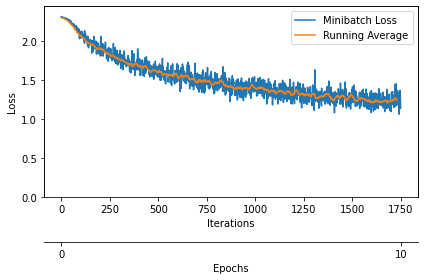

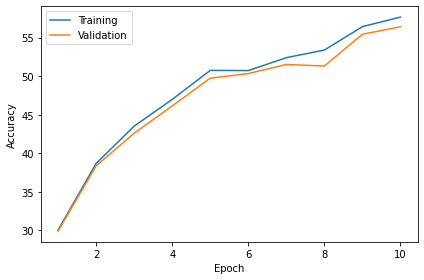

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

# plt.ylim([80, 100])
plt.show()

In [ ]:
class CNN2(torch.nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.features = torch.nn.Sequential(
            # Conv 1
            torch.nn.Conv2d(3, 16, kernel_size=3, padding="same"), # output 16 - 3 + 1 => 16
                            # , stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), # 16 / 2 => output 8

            # Conv 2
            torch.nn.Conv2d(16, 32, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 8
                            # , padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), #output 8 / 2 => output 4

            # Conv 3
            torch.nn.Conv2d(32, 64, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 4
                            # , padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2) #output 4 / 2 => output 2

    )

    self.classifier = torch.nn.Sequential(
         torch.nn.Linear(64*2*2, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    # print(x.size())
    logits = self.classifier(x)
    return logits

In [ ]:
model2 = CNN2(num_classes=10)

In [ ]:
model2 = model2.to(DEVICE)

In [ ]:
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.1)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list2, train_acc_list2, valid_acc_list2 = train_model(
    model=model2,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer2,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

Epoch: 001/010 | Batch 0000/0175 | Loss: 2.3064
Epoch: 001/010 | Batch 0100/0175 | Loss: 2.2864
Epoch: 001/010 | Train: 22.01% | Validation: 21.94%
Time elapsed: 1.05 min
Epoch: 002/010 | Batch 0000/0175 | Loss: 2.1762
Epoch: 002/010 | Batch 0100/0175 | Loss: 2.0107
Epoch: 002/010 | Train: 28.13% | Validation: 27.68%
Time elapsed: 2.08 min
Epoch: 003/010 | Batch 0000/0175 | Loss: 1.9441
Epoch: 003/010 | Batch 0100/0175 | Loss: 1.7988
Epoch: 003/010 | Train: 34.48% | Validation: 34.52%
Time elapsed: 3.12 min
Epoch: 004/010 | Batch 0000/0175 | Loss: 1.7538
Epoch: 004/010 | Batch 0100/0175 | Loss: 1.6146
Epoch: 004/010 | Train: 38.63% | Validation: 38.98%
Time elapsed: 4.15 min
Epoch: 005/010 | Batch 0000/0175 | Loss: 1.6855
Epoch: 005/010 | Batch 0100/0175 | Loss: 1.8705
Epoch: 005/010 | Train: 41.14% | Validation: 41.40%
Time elapsed: 5.17 min
Epoch: 006/010 | Batch 0000/0175 | Loss: 1.5370
Epoch: 006/010 | Batch 0100/0175 | Loss: 1.6231
Epoch: 006/010 | Train: 40.54% | Validation: 41.2

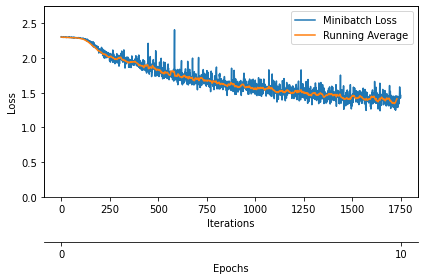

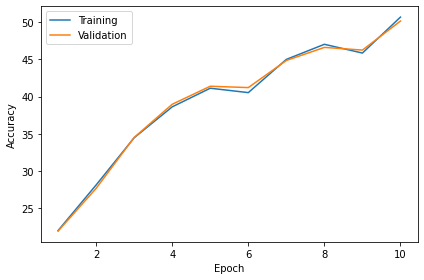

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list2,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list2,
              valid_acc_list=valid_acc_list2,
              results_dir=None)

# plt.ylim([80, 100])
plt.show()

## Data Augmentation

In [ ]:
training_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((16, 16)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomRotation(degrees=30, interpolation=PIL.Image.BILINEAR),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = torchvision.transforms.Compose([
      torchvision.transforms.Resize((16, 16)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



train_loader_augmented, valid_loader_augmented, test_loader_augmented = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1306: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


Files already downloaded and verified


In [ ]:
model1_augmented = CNN1(num_classes=10)

In [ ]:
model1_augmented = model1_augmented.to(DEVICE)

In [ ]:
optimizer_augmented = torch.optim.SGD(model1_augmented.parameters(), lr=0.1)
scheduler_augmented = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list_augmented1, train_acc_list_augmented1, valid_acc_list_augmented1 = train_model(
    model=model1_augmented,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader_augmented,
    valid_loader=valid_loader_augmented,
    test_loader=test_loader_augmented,
    optimizer=optimizer_augmented,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

Epoch: 001/200 | Batch 0000/0175 | Loss: 2.3148
Epoch: 001/200 | Batch 0100/0175 | Loss: 2.1903
Epoch: 001/200 | Train: 29.50% | Validation: 29.52%
Time elapsed: 1.03 min
Epoch: 002/200 | Batch 0000/0175 | Loss: 1.8754
Epoch: 002/200 | Batch 0100/0175 | Loss: 1.8607
Epoch: 002/200 | Train: 37.80% | Validation: 38.42%
Time elapsed: 2.04 min
Epoch: 003/200 | Batch 0000/0175 | Loss: 1.6420
Epoch: 003/200 | Batch 0100/0175 | Loss: 1.6492
Epoch: 003/200 | Train: 44.00% | Validation: 42.74%
Time elapsed: 3.03 min
Epoch: 004/200 | Batch 0000/0175 | Loss: 1.5914
Epoch: 004/200 | Batch 0100/0175 | Loss: 1.6133
Epoch: 004/200 | Train: 45.89% | Validation: 45.44%
Time elapsed: 4.05 min
Epoch: 005/200 | Batch 0000/0175 | Loss: 1.4920
Epoch: 005/200 | Batch 0100/0175 | Loss: 1.4084
Epoch: 005/200 | Train: 49.60% | Validation: 49.00%
Time elapsed: 5.05 min
Epoch: 006/200 | Batch 0000/0175 | Loss: 1.3994
Epoch: 006/200 | Batch 0100/0175 | Loss: 1.3412
Epoch: 006/200 | Train: 51.70% | Validation: 51.1

KeyboardInterrupt: ignored

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list_augmented1,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list_augmented1,
              valid_acc_list=valid_acc_list_augmented1,
              results_dir=None)

plt.ylim([80, 100])
plt.show()

NameError: ignored

## Dropout

In [ ]:
class CNN1Dropout(torch.nn.Module):
  def __init__(self, num_classes, drop_probas=[]):
    super().__init__()
    self.features = torch.nn.Sequential(
            # Conv 1
            torch.nn.Conv2d(3, 16, kernel_size=3, padding="same"), # output 16 - 3 + 1 => 16
                            # , stride=4, padding=2),
            torch.nn.Dropout2d(p=drop_probas[0]),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), # 16 / 2 => output 8

            # Conv 2
            torch.nn.Conv2d(16, 32, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 8
                            # , padding=2),
            torch.nn.Dropout2d(p=drop_probas[1]),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2) #output 8 / 2 => output 4
    )

    self.classifier = torch.nn.Sequential(
         torch.nn.Linear(32*4*4, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    # print(x.size())
    logits = self.classifier(x)
    return logits

In [ ]:
model_dropout = CNN1Dropout(num_classes=10, drop_probas=[0.5, 0.5])

In [ ]:
model_dropout = model_dropout.to(DEVICE)

In [ ]:
optimizer_dropout = torch.optim.SGD(model_dropout.parameters(), lr=0.1)
scheduler_dropout = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list_dropout, train_acc_list_dropout, valid_acc_list_dropout = train_model(
    model=model_dropout,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer_dropout,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6381a9e5f0>


Epoch: 001/010 | Batch 0000/0175 | Loss: 2.3020


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6381a9e5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.

Epoch: 001/010 | Batch 0100/0175 | Loss: 2.3109
Epoch: 001/010 | Train: 6.17% | Validation: 6.30%
Time elapsed: 1.04 min
Epoch: 002/010 | Batch 0000/0175 | Loss: 2.3064
Epoch: 002/010 | Batch 0100/0175 | Loss: 2.3031
Epoch: 002/010 | Train: 6.17% | Validation: 6.30%
Time elapsed: 2.09 min
Epoch: 003/010 | Batch 0000/0175 | Loss: 2.3146
Epoch: 003/010 | Batch 0100/0175 | Loss: 2.3152
Epoch: 003/010 | Train: 6.17% | Validation: 6.30%
Time elapsed: 3.21 min
Epoch: 004/010 | Batch 0000/0175 | Loss: 2.3025
Epoch: 004/010 | Batch 0100/0175 | Loss: 2.3094
Epoch: 004/010 | Train: 6.15% | Validation: 6.30%
Time elapsed: 4.27 min
Epoch: 005/010 | Batch 0000/0175 | Loss: 2.2981
Epoch: 005/010 | Batch 0100/0175 | Loss: 2.3052
Epoch: 005/010 | Train: 6.15% | Validation: 6.30%
Time elapsed: 5.38 min
Epoch: 006/010 | Batch 0000/0175 | Loss: 2.3051
Epoch: 006/010 | Batch 0100/0175 | Loss: 2.3033
Epoch: 006/010 | Train: 6.16% | Validation: 6.30%
Time elapsed: 6.43 min
Epoch: 007/010 | Batch 0000/0175 |

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list_dropout,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list_dropout,
              valid_acc_list=valid_acc_list_dropout,
              results_dir=None)

plt.ylim([80, 100])
plt.show()

In [ ]:
class CNN2Dropout(torch.nn.Module):
  def __init__(self, num_classes, drop_probas=[]):
    super().__init__()
    self.features = torch.nn.Sequential(
            # Conv 1
            torch.nn.Conv2d(3, 16, kernel_size=3, padding="same"), # output 16 - 3 + 1 => 16
                            # , stride=4, padding=2),
            torch.nn.Dropout2d(p=drop_probas[0]),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), # 16 / 2 => output 8

            # Conv 2
            torch.nn.Conv2d(16, 32, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 8
                            # , padding=2),
            torch.nn.Dropout2d(p=drop_probas[1]),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), #output 8 / 2 => output 4

            # Conv 3
            torch.nn.Conv2d(32, 64, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 4
                            # , padding=2),
            torch.nn.Dropout2d(p=drop_probas[2]),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2) #output 4 / 2 => output 2

    )

    self.classifier = torch.nn.Sequential(
         torch.nn.Linear(64*2*2, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    # print(x.size())
    logits = self.classifier(x)
    return logits

In [ ]:
model2_dropout = CNN2Dropout(num_classes=10, drop_probas=[0.2, 0.4, 0.8])

In [ ]:
model2_dropout = model2_dropout.to(DEVICE)

In [ ]:
optimizer2_dropout = torch.optim.SGD(model2_dropout.parameters(), lr=0.1)
scheduler2_dropout = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list_dropout2, train_acc_list_dropout2, valid_acc_list_dropout2 = train_model(
    model=model2_dropout,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer2_dropout,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

Epoch: 001/010 | Batch 0000/0175 | Loss: 2.3010
Epoch: 001/010 | Batch 0100/0175 | Loss: 2.3011
Epoch: 001/010 | Train: 11.75% | Validation: 12.00%
Time elapsed: 1.02 min
Epoch: 002/010 | Batch 0000/0175 | Loss: 2.3077
Epoch: 002/010 | Batch 0100/0175 | Loss: 2.2993
Epoch: 002/010 | Train: 11.76% | Validation: 12.00%
Time elapsed: 2.04 min
Epoch: 003/010 | Batch 0000/0175 | Loss: 2.3054
Epoch: 003/010 | Batch 0100/0175 | Loss: 2.3080
Epoch: 003/010 | Train: 11.73% | Validation: 12.00%
Time elapsed: 3.08 min
Epoch: 004/010 | Batch 0000/0175 | Loss: 2.3050
Epoch: 004/010 | Batch 0100/0175 | Loss: 2.2970
Epoch: 004/010 | Train: 11.74% | Validation: 12.00%
Time elapsed: 4.11 min
Epoch: 005/010 | Batch 0000/0175 | Loss: 2.3085
Epoch: 005/010 | Batch 0100/0175 | Loss: 2.3123
Epoch: 005/010 | Train: 11.75% | Validation: 12.00%
Time elapsed: 5.13 min
Epoch: 006/010 | Batch 0000/0175 | Loss: 2.3067
Epoch: 006/010 | Batch 0100/0175 | Loss: 2.2995
Epoch: 006/010 | Train: 11.73% | Validation: 12.0

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list_dropout2,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list_dropout2,
              valid_acc_list=valid_acc_list_dropout2,
              results_dir=None)

plt.ylim([80, 100])
plt.show()

## Optimser changes

In [ ]:
class CNN1RMS(torch.nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.features = torch.nn.Sequential(
            # Conv 1
            torch.nn.Conv2d(3, 16, kernel_size=3, padding="same"), # output 16 - 3 + 1 => 16
                            # , stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), # 16 / 2 => output 8

            # Conv 2
            torch.nn.Conv2d(16, 32, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 8
                            # , padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2) #output 8 / 2 => output 4
    )

    self.classifier = torch.nn.Sequential(
         torch.nn.Linear(32*4*4, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    # print(x.size())
    logits = self.classifier(x)
    return logits

In [ ]:
model1_rms = CNN1RMS(num_classes=10)

In [ ]:
model1_rms = model1_rms.to(DEVICE)

In [ ]:
optimizer_rms = torch.optim.RMSprop(model1_rms.parameters())
scheduler_rms = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_rms,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list_rms, train_acc_list_rms, valid_acc_list_rms = train_model(
    model=model1_rms,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer_rms,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


Epoch: 001/010 | Batch 0000/0175 | Loss: 2.3034
Epoch: 001/010 | Batch 0100/0175 | Loss: 1.7305
Epoch: 001/010 | Train: 41.67% | Validation: 40.92%
Time elapsed: 1.11 min
Epoch: 002/010 | Batch 0000/0175 | Loss: 1.5331
Epoch: 002/010 | Batch 0100/0175 | Loss: 1.5468
Epoch: 002/010 | Train: 39.65% | Validation: 39.16%
Time elapsed: 2.12 min
Epoch: 003/010 | Batch 0000/0175 | Loss: 1.7793
Epoch: 003/010 | Batch 0100/0175 | Loss: 1.4540
Epoch: 003/010 | Train: 50.31% | Validation: 49.22%
Time elapsed: 3.13 min
Epoch: 004/010 | Batch 0000/0175 | Loss: 1.3717
Epoch: 004/010 | Batch 0100/0175 | Loss: 1.3267
Epoch: 004/010 | Train: 51.57% | Validation: 49.40%
Time elapsed: 4.15 min
Epoch: 005/010 | Batch 0000/0175 | Loss: 1.3942
Epoch: 005/010 | Batch 0100/0175 | Loss: 1.3168
Epoch: 005/010 | Train: 53.59% | Validation: 51.90%
Time elapsed: 5.14 min
Epoch: 006/010 | Batch 0000/0175 | Loss: 1.4118
Epoch: 006/010 | Batch 0100/0175 | Loss: 1.2901
Epoch: 006/010 | Train: 55.61% | Validation: 52.9

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list_rms,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list_rms,
              valid_acc_list=valid_acc_list_rms,
              results_dir=None)

plt.ylim([80, 100])
plt.show()

In [ ]:
class CNN2Adam(torch.nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.features = torch.nn.Sequential(
            # Conv 1
            torch.nn.Conv2d(3, 16, kernel_size=3, padding="same"), # output 16 - 3 + 1 => 16
                            # , stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), # 16 / 2 => output 8

            # Conv 2
            torch.nn.Conv2d(16, 32, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 8
                            # , padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), #output 8 / 2 => output 4

            # Conv 3
            torch.nn.Conv2d(32, 64, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 4
                            # , padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2) #output 4 / 2 => output 2

    )

    self.classifier = torch.nn.Sequential(
         torch.nn.Linear(64*2*2, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    # print(x.size())
    logits = self.classifier(x)
    return logits

In [ ]:
model2_adam = CNN2Adam(num_classes=10)

In [ ]:
model2_adam = model2_adam.to(DEVICE)

In [ ]:
optimizer_adam = torch.optim.Adam(model2_adam.parameters())
scheduler_rms = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_adam,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list_adam, train_acc_list_adam, valid_acc_list_adam = train_model(
    model=model2_adam,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer_adam,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

Epoch: 001/010 | Batch 0000/0175 | Loss: 2.3067
Epoch: 001/010 | Batch 0100/0175 | Loss: 1.8229
Epoch: 001/010 | Train: 38.16% | Validation: 38.88%
Time elapsed: 1.09 min
Epoch: 002/010 | Batch 0000/0175 | Loss: 1.7034
Epoch: 002/010 | Batch 0100/0175 | Loss: 1.5474
Epoch: 002/010 | Train: 43.90% | Validation: 43.68%
Time elapsed: 2.11 min
Epoch: 003/010 | Batch 0000/0175 | Loss: 1.5716
Epoch: 003/010 | Batch 0100/0175 | Loss: 1.4982
Epoch: 003/010 | Train: 45.99% | Validation: 45.74%
Time elapsed: 3.11 min
Epoch: 004/010 | Batch 0000/0175 | Loss: 1.4296
Epoch: 004/010 | Batch 0100/0175 | Loss: 1.3897
Epoch: 004/010 | Train: 48.71% | Validation: 48.54%
Time elapsed: 4.11 min
Epoch: 005/010 | Batch 0000/0175 | Loss: 1.3245
Epoch: 005/010 | Batch 0100/0175 | Loss: 1.3328
Epoch: 005/010 | Train: 50.78% | Validation: 49.98%
Time elapsed: 5.10 min
Epoch: 006/010 | Batch 0000/0175 | Loss: 1.4362
Epoch: 006/010 | Batch 0100/0175 | Loss: 1.3799
Epoch: 006/010 | Train: 52.13% | Validation: 51.3

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list_adam,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list_adam,
              valid_acc_list=valid_acc_list_adam,
              results_dir=None)

plt.ylim([80, 100])
plt.show()